### 15.1 Standard RNN and Stacked RNN

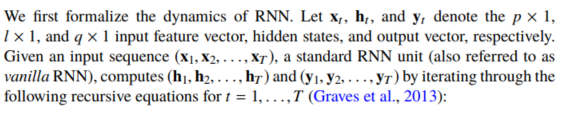

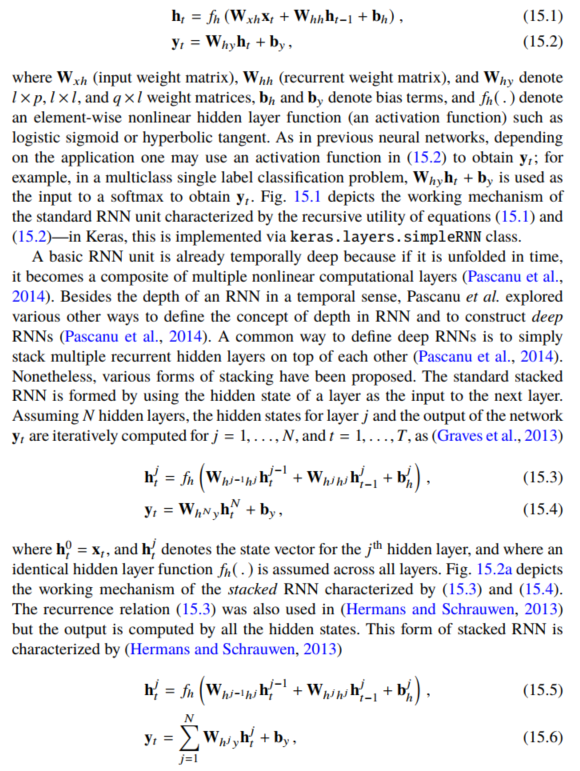

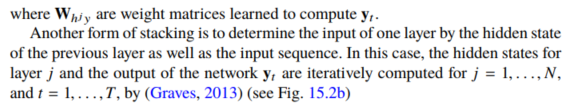

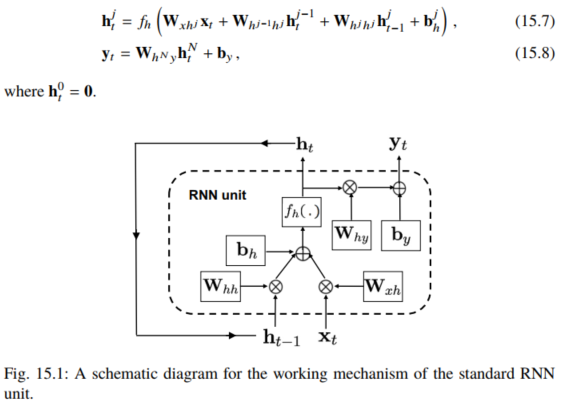

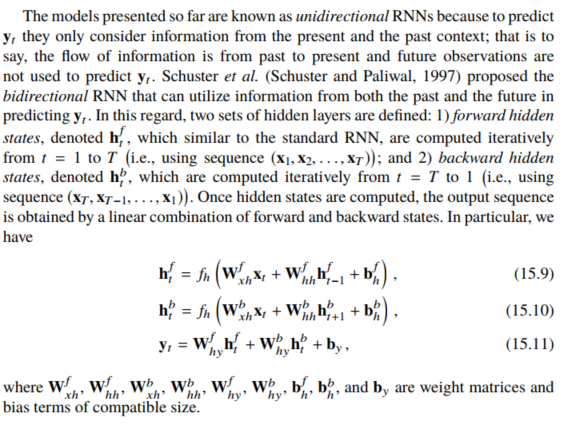

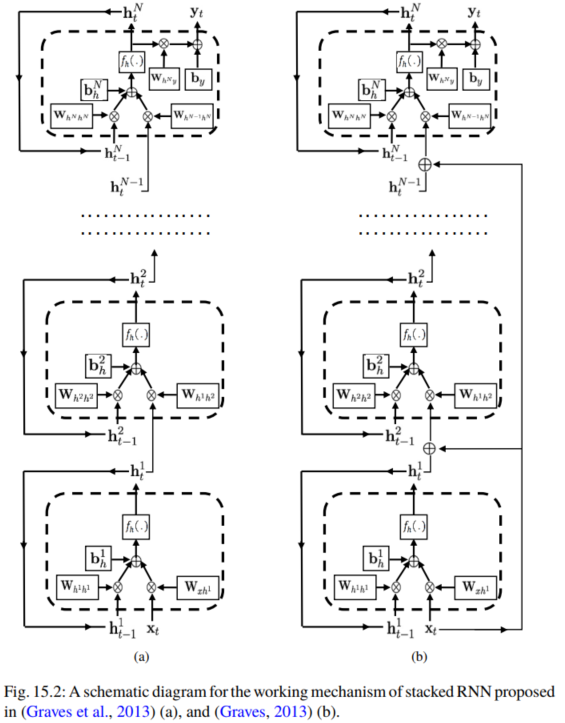

### 15.2 Vanishing and Exploding Gradient Problems

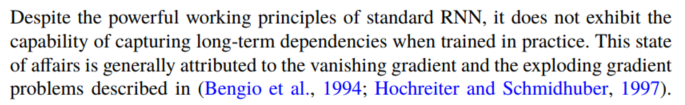

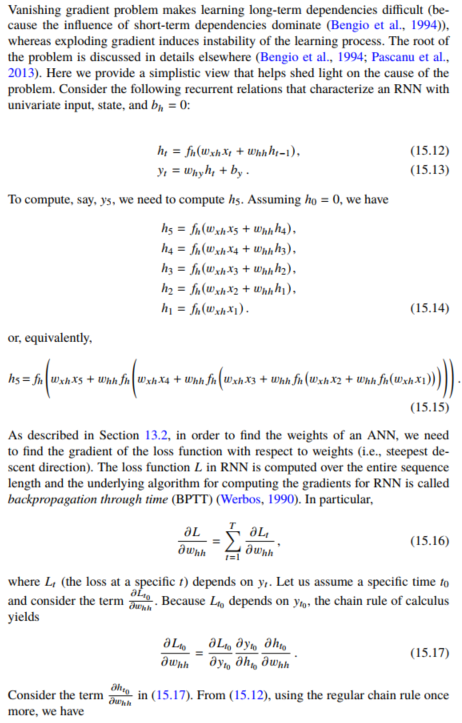

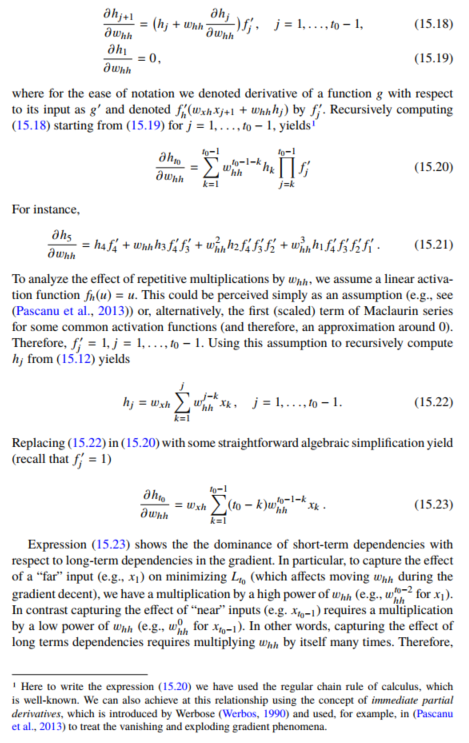

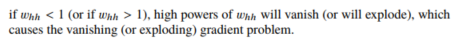

### 15.3 LSTM and GRU

- To alleviate the vanishing gradient problem (gating mechanism)
- Not only LSTM can propagate information by its additive memory, it also learns when to forget or keep the memory, which is a powerful feature of “gated RNNs”
- GRU, on the other hand, is a simpler network architecture than LSTM, which makes it more efficient to train. At the same time, it has shown comparable performances to LSTM

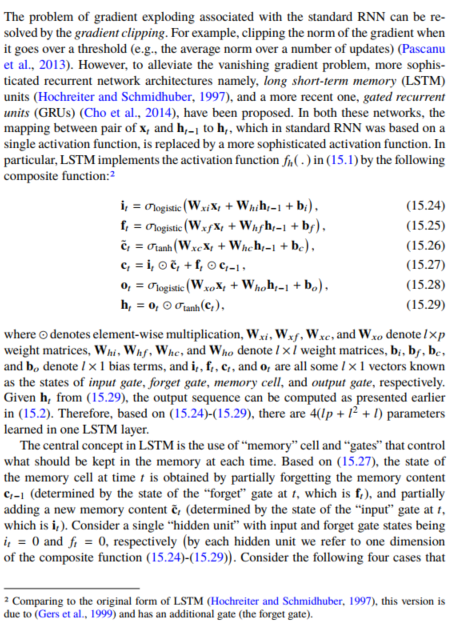

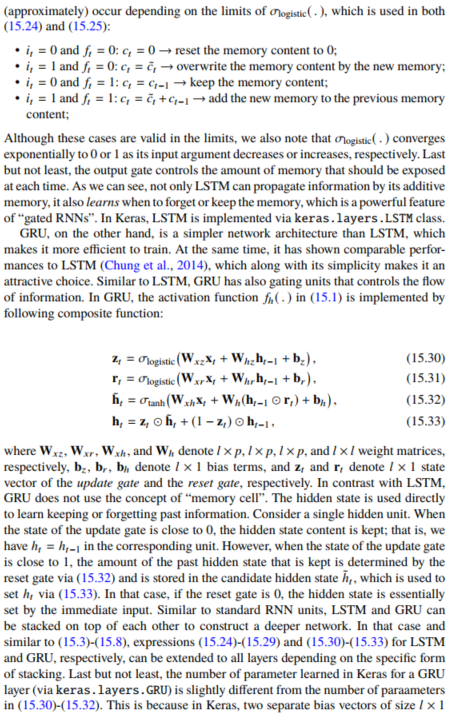

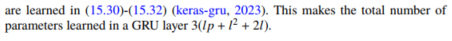

### 15.4 Implementation in Keras: Sentiment Classification

In [5]:
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
# from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
seed_value= 42

# set the seed for Python built-in pseudo-random generator
import random
random.seed(seed_value)

# set the seed for numpy pseudo-random generator
import numpy as np
np.random.seed(seed_value)

# set the seed for tensorflow pseudo-random generator
tf.random.set_seed(seed_value)

In [9]:
# load the training (+ validation) data for positive and negative reviews, concatenate them, and generate the labels
directory = "./aclImdb/train/pos" # replace ... by the path to "aclImdb", which contains the downloaded data
X_train_val_pos = keras.utils.text_dataset_from_directory(directory=directory, batch_size = None, label_mode=None, shuffle=False)
directory = "./aclImdb/train/neg"
X_train_val_neg = keras.utils.text_dataset_from_directory(directory=directory, batch_size = None, label_mode=None, shuffle=False)
X_train_val = X_train_val_pos.concatenate(X_train_val_neg)
y_train_val = np.array([0]*len(X_train_val_pos) + [1]*len(X_train_val_neg))

Found 12500 files belonging to 1 classes.
Found 12500 files belonging to 1 classes.


In [11]:
# load the test data for positive and negative reviews, concatenate them, and generate the labels
directory = "./aclImdb/test/pos"
X_test_pos = keras.utils.text_dataset_from_directory(directory=directory, batch_size = None, label_mode=None, shuffle=False)
directory = "./aclImdb/test/neg"
X_test_neg = keras.utils.text_dataset_from_directory(directory=directory, batch_size = None, label_mode=None, shuffle=False)
X_test = X_test_pos.concatenate(X_test_neg)
y_test = np.array([0]*len(X_test_pos) + [1]*len(X_test_neg))

Found 12500 files belonging to 1 classes.
Found 12500 files belonging to 1 classes.


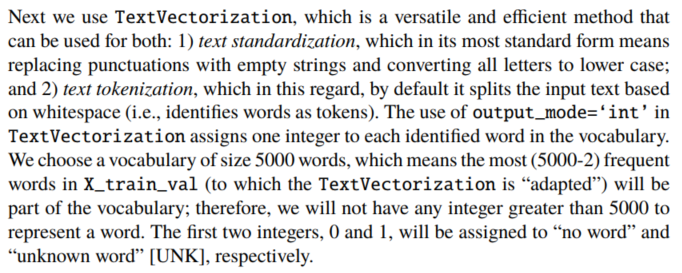

In [12]:
# use TextVectorization to learn (by "adapt()" method) the vocabulary from X_train_val
from tensorflow.keras.layers import TextVectorization as TV
vocab_size = 5000
tv = TV(max_tokens=vocab_size, output_mode='int')
tv.adapt(X_train_val)
print("Total number of words in the dictionary: ", len(tv.get_vocabulary()))

Total number of words in the dictionary:  5000


Next we use the learned vocabulary to transform each sequence of words that are part of `X_train_val` into corresponding sequence of integers.

In [13]:
# encode each sequence ("seq") that is part of the X_train_val Dataset object using the learned vocabulary
X_train_val_int_encoded_var_len = []
for seq in X_train_val:
  seq_encoded = tv([seq]).numpy()[0]
  X_train_val_int_encoded_var_len.append(seq_encoded)
X_train_val_int_encoded_var_len[0]

array([   1,  322,    7,    4, 1078,  220,    9, 2085,   31,    2,  167,
         62,   15,   47,   81,    1,   43,  400,  119,  136,   15, 4894,
         56,    1,  148,    8,    2, 4946,    1,  480,   70,    6,  256,
         12,    1,    1, 1972,    7,   73, 2363,    6,  641,   71,    7,
       4894,    2,    1,    6, 2031,    1,    2,    1, 1422,   37,   69,
         68,  205,  141,   65, 1216, 4894,    1,    2,    1,    5,    2,
        219,  904,   32, 2929,   70,    5,    2, 4711,   10,  672,    3,
         65, 1422,   51,   10,  208,    2,  383,    8,   60,    4, 1474,
       3622,  775,    6, 3580,  187,    2,  400,   10, 1192,    1,   31,
        322,    4,  350,  363, 2971,  142,  132,    6,    1,   29,    5,
        123, 4894, 1474, 2409,    6,    1,  322,   10,  517,   12,  106,
       1471,    5,   56,  582,  103,   12,    1,  322,    7,  234,    1,
         49,    4, 2292,   12,    9,  207], dtype=int64)

If desired, we can convert back the sequence of integers into words.

In [14]:
# decode an encoded sequence back to words
inverse_vocabulary = dict(enumerate(tv.get_vocabulary()))
decoded_sentence = " ".join(inverse_vocabulary[i] for i in X_train_val_int_encoded_var_len[0])
decoded_sentence

'[UNK] high is a cartoon comedy it ran at the same time as some other [UNK] about school life such as teachers my [UNK] years in the teaching [UNK] lead me to believe that [UNK] [UNK] satire is much closer to reality than is teachers the [UNK] to survive [UNK] the [UNK] students who can see right through their pathetic teachers [UNK] the [UNK] of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately [UNK] at high a classic line inspector im here to [UNK] one of your teachers student welcome to [UNK] high i expect that many adults of my age think that [UNK] high is far [UNK] what a pity that it isnt'

In [15]:
# encode each sequence ("seq") that is part of the X_test Dataset object using the learned vocabulary
X_test_int_encoded_var_len = []
for seq in X_test:
  seq_encoded = tv([seq]).numpy()[0]
  X_test_int_encoded_var_len.append(seq_encoded)
X_test_int_encoded_var_len[0]

Until now the encoded sequence of reviews have different length. However, for
training, we need sequences of the same length. Here we choose the first 200 words
(that are of course part of the learned vocabulary) of each sequence. In this regard,
we pad the sequences. Those that are shorter will be (by default) pre-padded by zeros
to become 200 long.

In [ ]:
# unify the length of each encoded review to a sequence_len. If the
# review is longer, it is cropped and if it is shorter it will padded
# by zeros (by default)
sequence_len = 200
X_train_val_padded_fixed_len = keras.utils.pad_sequences(X_train_val_int_encoded_var_len, maxlen=sequence_len)
X_test_padded_fixed_len = keras.utils.pad_sequences(X_test_int_encoded_var_len, maxlen=sequence_len)
X_train_val_padded_fixed_len[0:2]

Word embedding layer:
- Boost performace and speed up the training
- Represent each word by a relatively low-dimensional vector, which is learned during the training process

In word embedding, which is implemented by
`keras.layers.Embedding`, we represent each word with a low-dimensional vector
(the dimension is a hyperparameter) where each element of this vector is estimated
through the learning algorithm

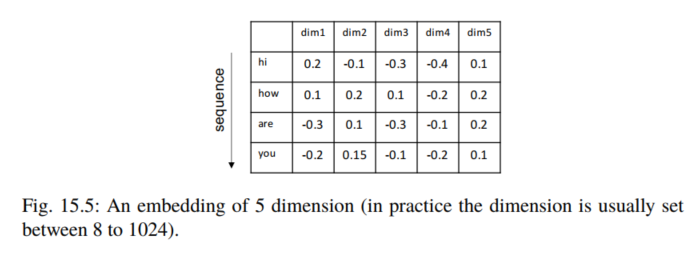

Given a batch of word sequences of
size “samples × sequence length”, the embedding “layer” in Keras returns a tensor
of size “samples × sequence length × embedding dimensionality”. Next, we use an
embedding 16-dimensional layer, a GRU with 32 hidden units, and early stopping
call back with a patience parameter of 3 to train our classifier. The classifier shows
an accuracy of 86.4% on the test set.

In [ ]:
# split the training+validation data into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_val_padded_fixed_len, y_train_val, stratify=y_train_val, test_size=0.25)

# build the model
imdb_model = keras.Sequential([
  layers.Embedding(vocab_size, 16),
  layers.GRU(32, input_shape=(None, 1)),
  layers.Dense(1, activation='sigmoid')
])

# compiling model

imdb_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# training model
my_callbacks = [
  keras.callbacks.EarlyStopping(
  monitor="val_accuracy",
  patience=3),
  keras.callbacks.ModelCheckpoint(
  filepath="best_model.keras",
  monitor="val_accuracy",
  save_best_only=True,
  verbose=1)
]

history = imdb_model.fit(x = X_train,
  y = y_train,
  batch_size = 32,
  epochs = 100,
  validation_data = (X_val, y_val),
  callbacks=my_callbacks)

In [ ]:
print(history.history.keys())
print(imdb_model.summary())

# plotting the results
epoch_count = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(13,4), dpi=150)
plt.subplot(121)
plt.plot(epoch_count, history.history['loss'], 'b', label = 'training loss')
plt.plot(epoch_count, history.history['val_loss'], 'r', label = 'validation loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.subplot(122)
plt.plot(epoch_count, history.history['accuracy'], 'b', label = 'training accuracy')
plt.plot(epoch_count, history.history['val_accuracy'], 'r', label = 'validation accuracy')
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('epoch')
best_imdb_model = keras.models.load_model("best_model.keras")
loss, accuracy = best_imdb_model.evaluate(X_test_padded_fixed_len, y_test, verbose=1)
print('Test accuracy = {:.3f}'.format(accuracy))